In [20]:
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV  
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import math

In [21]:
gold = pd.read_csv('gld_price_data.csv')

In [22]:
gold.head()

,Date,SPX,GLD,USO,SLV,EUR/USD
0,1/2/2008,1447.160034,84.860001,78.470001,15.180,1.471692
1,1/3/2008,1447.160034,85.570000,78.370003,15.285,1.474491
2,1/4/2008,1411.630005,85.129997,77.309998,15.167,1.475492
3,1/7/2008,1416.180054,84.769997,75.500000,15.053,1.468299
4,1/8/2008,1390.189941,86.779999,76.059998,15.590,1.557099


In [23]:
gold.tail()

,Date,SPX,GLD,USO,SLV,EUR/USD
2285,5/8/2018,2671.919922,124.589996,14.0600,15.5100,1.186789
2286,5/9/2018,2697.790039,124.330002,14.3700,15.5300,1.184722
2287,5/10/2018,2723.070068,125.180000,14.4100,15.7400,1.191753
2288,5/14/2018,2730.129883,124.489998,14.3800,15.5600,1.193118
2289,5/16/2018,2725.780029,122.543800,14.4058,15.4542,1.182033


In [24]:
gold.shape

(2290, 6)

In [25]:
gold.isnull().sum()

Date       0
SPX        0
GLD        0
USO        0
SLV        0
EUR/USD    0
dtype: int64

<Axes: >

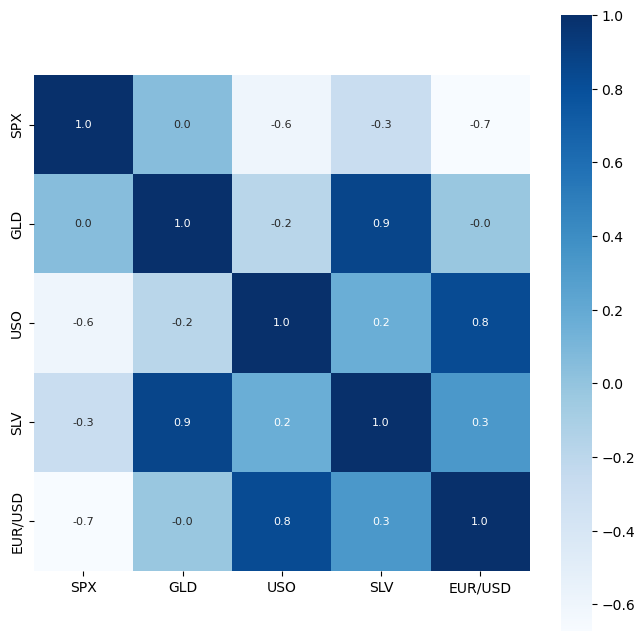

In [26]:
correlation = gold.drop(['Date'],axis=1).corr()
plt.figure(figsize = (8,8))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size': 8}, cmap='Blues')

In [27]:
print(correlation['GLD'])

SPX        0.049345
GLD        1.000000
USO       -0.186360
SLV        0.866632
EUR/USD   -0.024375
Name: GLD, dtype: float64


In [28]:
x = gold.drop(['Date','GLD'], axis=1)
y = gold['GLD']

In [29]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=3)

In [30]:
def evaluate_model(model, x_train, y_train, x_test, y_test):
    # Train the model
    model.fit(x_train, y_train)
    # Predictions on test data
    predictions = model.predict(x_test)
    
    # Calculate evaluation metrics
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = math.sqrt(mse)
    
    return r2, mae, mse, rmse

In [31]:
models = {
    "Random Forest Regression": RandomForestRegressor(n_estimators=100),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Support Vector Regression": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=3),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=3),
    "Extra Trees Regressor" : ExtraTreesRegressor()
}

In [32]:
#Feature Scaling for SVR
scaler = StandardScaler()
xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled = scaler.transform(xtest)

In [33]:
# Hyperparameter tuning for SVR using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1],
    'kernel': ['linear', 'rbf']
}

svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=5, n_jobs=-1)
grid_search.fit(xtrain_scaled, ytrain)

# Get the best model from GridSearchCV
best_svr = grid_search.best_estimator_

In [34]:
results = {}

In [35]:
for model_name, model in models.items():
    if model_name == "Support Vector Regression":
        # For SVR, use the tuned model (best found by GridSearchCV)
        r2, mae, mse, rmse = evaluate_model(best_svr, xtrain_scaled, ytrain, xtest_scaled, ytest)
    else:
        r2, mae, mse, rmse = evaluate_model(model, xtrain, ytrain, xtest, ytest)

    results[model_name] = {
        "R²": r2,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse
    }

In [36]:
results_df = pd.DataFrame(results).T

C:\Users\Aryan\AppData\Local\Temp\ipykernel_16884\4274162661.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(results_df.index, rotation=45)
C:\Users\Aryan\AppData\Local\Temp\ipykernel_16884\4274162661.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(results_df.index, rotation=45)
C:\Users\Aryan\AppData\Local\Temp\ipykernel_16884\4274162661.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(results_df.index, rotation=45)
C:\Users\Aryan\AppData\Local\Temp\ipykernel_16884\4274162661.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(results

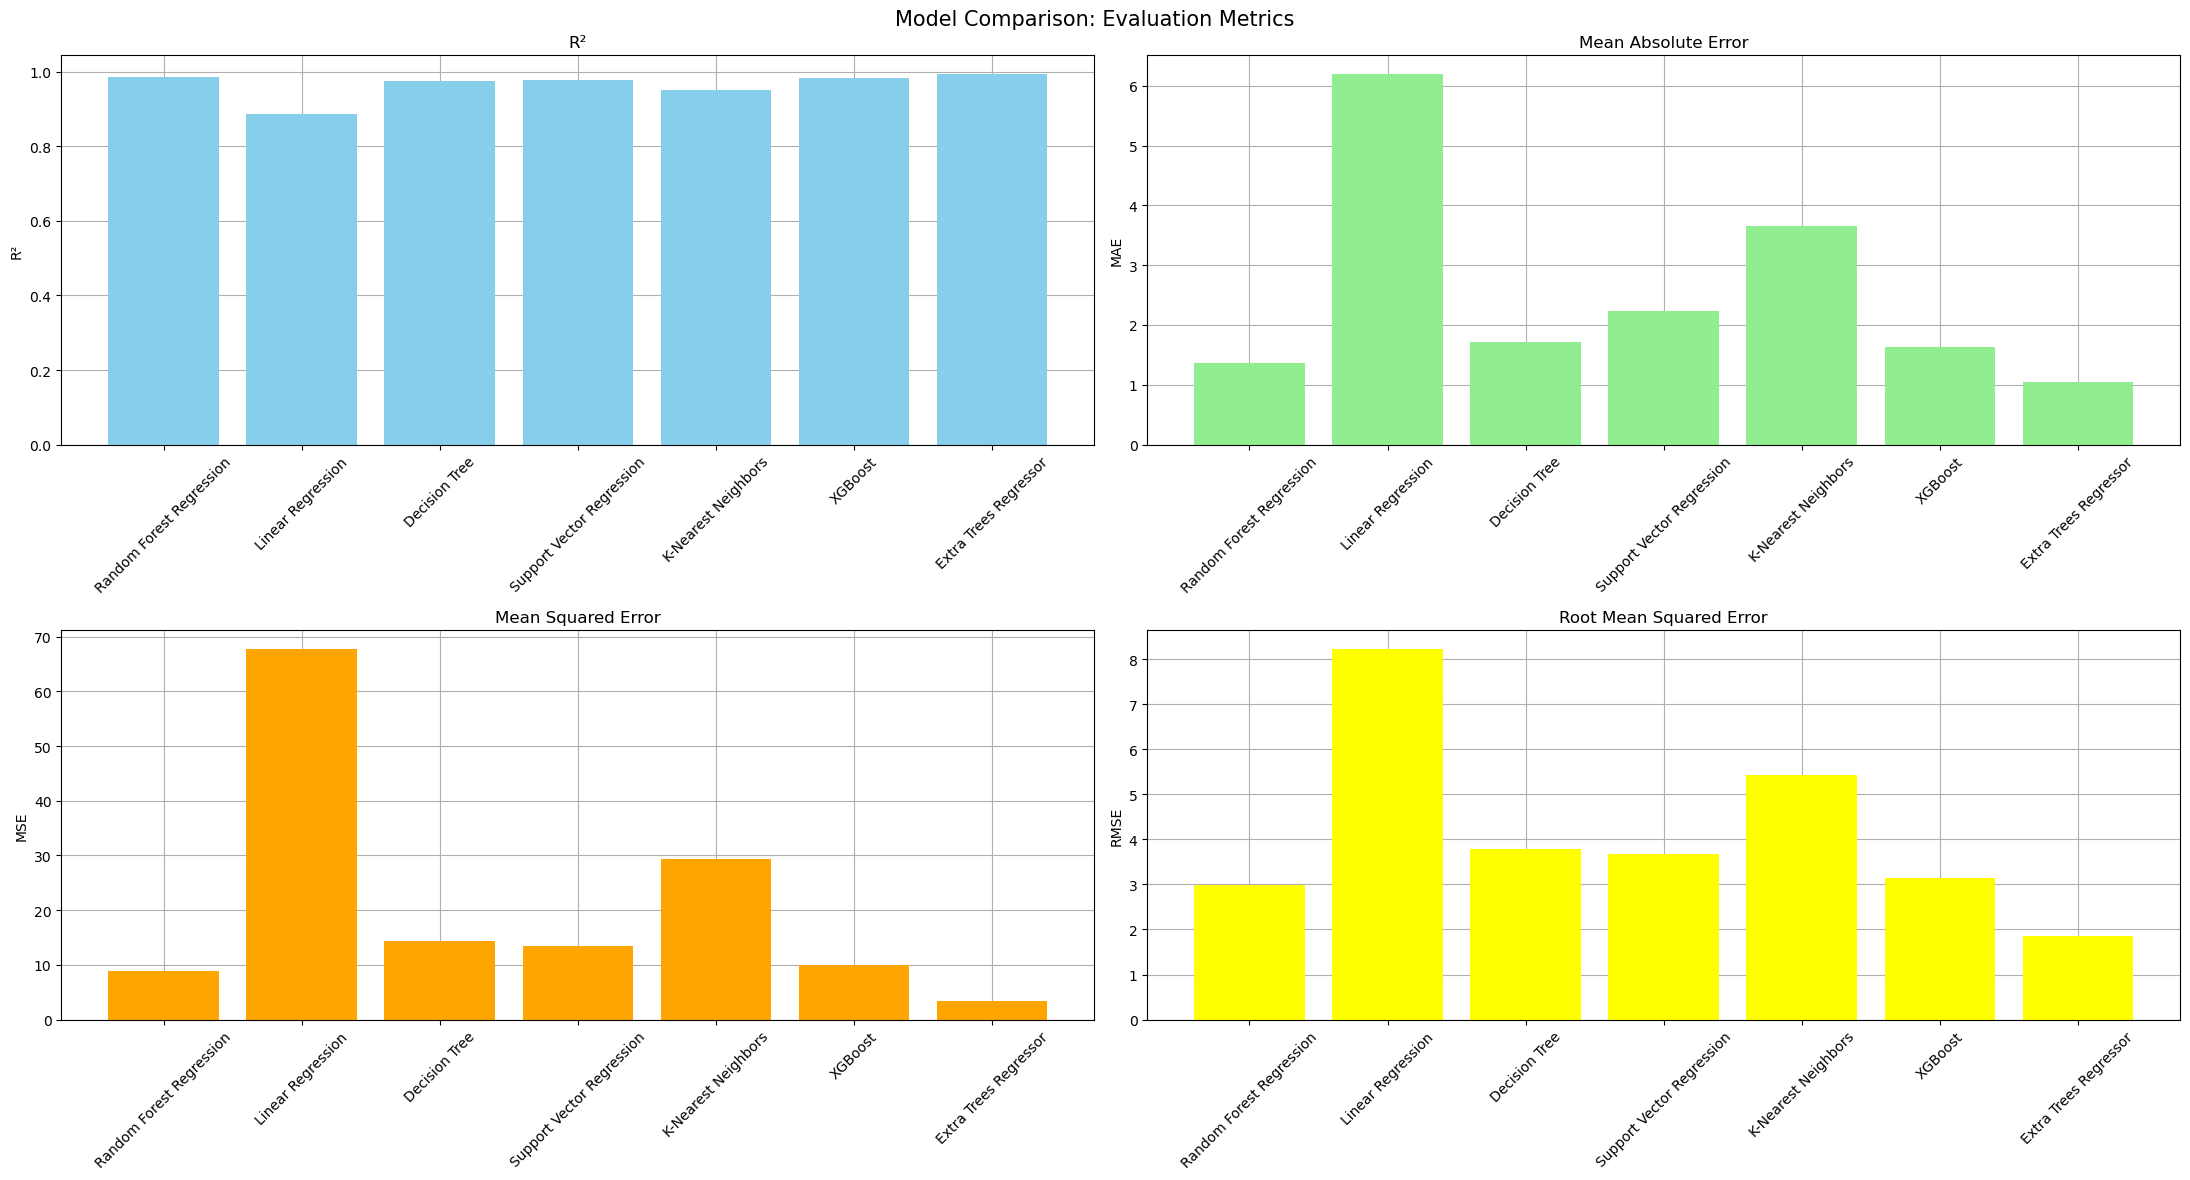

Model Evaluation Summary:
                                 R²       MAE        MSE      RMSE
Random Forest Regression   0.985153  1.369948   8.957761  2.992952
Linear Regression          0.887698  6.198129  67.757704  8.231507
Decision Tree              0.976144  1.720524  14.393283  3.793848
Support Vector Regression  0.977654  2.233987  13.482392  3.671838
K-Nearest Neighbors        0.951269  3.647632  29.401930  5.422355
XGBoost                    0.983609  1.634454   9.889729  3.144794
Extra Trees Regressor      0.994310  1.043451   3.433040  1.852846


In [37]:
r2_scores = results_df['R²']
mae_scores = results_df['MAE']
mse_scores = results_df['MSE']
rmse_scores = results_df['RMSE']

fig, axes = plt.subplots(2, 2, figsize=(22, 12))
plt.title('Comparison of Regression Models')

# Line plot for R² scores
axes[0, 0].bar(results_df.index, r2_scores, color='skyblue', zorder=2)
axes[0, 0].set_title('R²')
axes[0, 0].set_ylabel('R²')
axes[0, 0].set_xticklabels(results_df.index, rotation=45)
axes[0, 0].grid(True)

# Line plot for MAE scores
axes[0, 1].bar(results_df.index, mae_scores, color='lightgreen', zorder=2)
axes[0, 1].set_title('Mean Absolute Error')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_xticklabels(results_df.index, rotation=45)
axes[0, 1].grid(True)

# Line plot for MSE scores
axes[1, 0].bar(results_df.index, mse_scores, color='orange', zorder=2)
axes[1, 0].set_title('Mean Squared Error')
axes[1, 0].set_ylabel('MSE')
axes[1, 0].set_xticklabels(results_df.index, rotation=45)
axes[1, 0].grid(True)

# Line plot for RMSE scores
axes[1, 1].bar(results_df.index, rmse_scores, color='yellow', zorder=2)
axes[1, 1].set_title('Root Mean Squared Error')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].set_xticklabels(results_df.index, rotation=45)
axes[1, 1].grid(True)

plt.suptitle('Model Comparison: Evaluation Metrics', fontsize=15)

plt.tight_layout()

plt.show()

print("Model Evaluation Summary:")
print(results_df)